In [1]:
import math
from random import choice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from pandas import Series
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from helper import StockHelper
from preproc import get_train_test_data


In [2]:
stocks = StockHelper.get_stock_symbol_mapping()
stock, symbol = choice(list(stocks.items()))


In [3]:
train_size = 0.9

train_data, test_data = get_train_test_data(symbol, 300, train_size)
print(train_data.tail(), test_data.head(), sep="\n")
train_values = train_data.values.reshape(-1, 1)
test_values = test_data.values.reshape(-1, 1)


date
2021-01-11    1451.45
2021-01-12    1481.00
2021-01-13    1470.65
2021-01-14    1468.75
2021-01-15    1466.65
Name: close_price, dtype: float64
date
2021-01-18    1483.10
2021-01-19    1503.85
2021-01-20    1492.00
2021-01-21    1474.80
2021-01-22    1443.55
Name: close_price, dtype: float64


In [4]:
sc = MinMaxScaler(feature_range=(0, 1))
train_values_scaled = sc.fit_transform(train_values)
window = 60

X_train = np.array([train_values_scaled[i - window:i, 0] for i in range(window, len(train_values_scaled))])
y_train = np.array([train_values_scaled[i, 0] for i in range(window, len(train_values_scaled))])

X_train = np.reshape(X_train, (*X_train.shape, 1))


In [5]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train, y_train, batch_size=32, epochs=200)


Epoch 1/200
7/7 [==============================] - 4s 46ms/step - loss: 0.2193
Epoch 2/200
7/7 [==============================] - 0s 43ms/step - loss: 0.0331
Epoch 3/200
7/7 [==============================] - 0s 43ms/step - loss: 0.0334
Epoch 4/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0271
Epoch 5/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0251
Epoch 6/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0219
Epoch 7/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0170
Epoch 8/200
7/7 [==============================] - 0s 42ms/step - loss: 0.0281
Epoch 9/200
7/7 [==============================] - 0s 44ms/step - loss: 0.0206


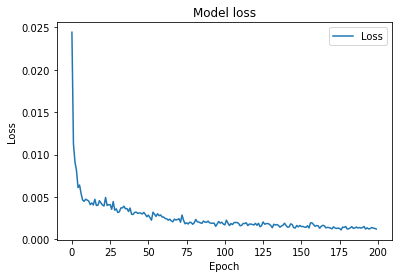

In [33]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label="Loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
dataset_total = pd.concat((train_data, test_data), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_data) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(window, len(inputs)):
    X_test.append(inputs[i - window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(30, 60, 1)


In [29]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

predictions = Series(predicted_stock_price.reshape(-1), test_data.index)


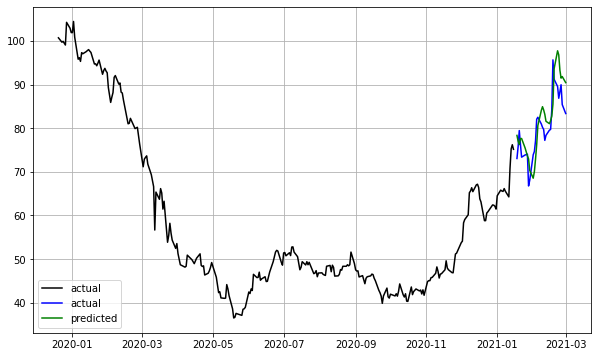

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_data, color="black", label="actual")
ax.plot(test_data, color="blue", label="actual")
ax.plot(predictions, color="green", label="predicted")
ax.grid(True)
ax.legend()
plt.show()


In [31]:
mae_score = mean_absolute_error(test_data, predictions)
print(f"MAE: {mae_score}")
rmse_score = math.sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE: {rmse_score}")
normalised_rmse_score = mean_squared_error(test_data, predictions, squared=False) / (
    test_data.max() - test_data.min()
)
print(f"NRMSE: {normalised_rmse_score}")
mape_score = np.mean(np.abs(predictions - test_data) / np.abs(test_data))
print(f"MAPE: {mape_score}")


MAE: 4.1631242879231785
RMSE: 4.869757813588717
NRMSE: 0.16850373057400403
MAPE: 0.05155384156353038
